# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [2]:
# 1.1 Place imports here
from typing import List, Optional

from collections import defaultdict
from dataclasses import dataclass

## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [3]:
# 2.1 Data Configuration
@dataclass
class DataConfig:
    input_path: str = "data/genehop.json"     # 数据输入文件
    output_dir: str = "results/"                 # 结果输出目录
    dataset_format: str = "json"                 # 数据格式
    task_field: str = "question"                 # 输入字段名
    answer_field: str = "answer"                 # 标准答案字段名
    split_key: str | None = None                 # 可选：用于分任务或切分数据

In [4]:
# 2.2 Model Configuration
@dataclass
class ModelConfig:
    model_name: str = "gpt-4.1"                     # "gpt-4", "gpt-3.5-turbo"
    max_tokens: int = 512
    temperature: float = 0.7
    top_p: float = 0.9
    top_k: Optional[int] = None                   
    use_cuda: bool = False                       
    batch_size: int = 1                        
    model_backend: str = "openai"                 
    model_variant: Optional[str] = None          
    openai_api_key: Optional[str] = None          
    openai_base_url: Optional[str] = "https://api.openai.com/v1"  


In [5]:
# 2.3 Evaluation and Logging Configuration
@dataclass
class EvaluationConfig:
    evaluate_per_task: bool = True              # 是否按任务类型评估（如问答 vs 生成）
    save_failed_cases: bool = True              # 是否保存失败样本
    failed_cases_path: str = "results/failed.json"  # 保存失败样本的位置
    metrics: tuple[str, ...] = ("accuracy",)    # 使用哪些指标，如 accuracy, f1

@dataclass
class LoggingConfig:
    enable_mlflow: bool = True                  # 是否启用 MLflow
    experiment_name: str = "GeneTuring-Run"     # MLflow 实验名
    run_name: Optional[str] = None              # 可选的具体 run 名称
    tracking_uri: Optional[str] = None          # 若设置为 None 则使用默认本地 URI
    log_artifacts: bool = True                  # 是否记录生成文件

## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [6]:
# 3.1 Load the JSON file

# Load the data here

# Build the TASKS variable here
import json
import pandas as pd
from typing import Dict, Any, List
import os
os.chdir("/project/bioinformatics/WZhang_lab/s440820/Module_3_Yi/project")

def load_and_flatten_gene_turing_data(config: DataConfig) -> pd.DataFrame:
    """
    Loads the nested GeneTuring QA dataset and flattens it into a dataframe.

    Args:
        config (DataConfig): Configuration containing the input file path.

    Returns:
        pd.DataFrame: A dataframe with columns ['task', 'question', 'answer']
    """
    # Step 1: Load raw nested JSON
    with open(config.input_path, "r") as f:
        raw_data: Dict[str, Dict[str, str]] = json.load(f)

    # Step 2: Flatten into list of dicts
    rows: List[Dict[str, Any]] = []
    for task_name, qa_pairs in raw_data.items():
        for question, answer in qa_pairs.items():
            rows.append({
                "task": task_name,
                "question": question,
                "answer": answer
            })

    # Step 3: Convert to DataFrame
    df = pd.DataFrame(rows)[["task", "question", "answer"]]

    return df
data_config = DataConfig(input_path="data/genehop.json")
df = load_and_flatten_gene_turing_data(data_config)
TASKS = set(df["task"])

print(f"Loaded {len(df)} examples across {len(TASKS)} tasks.")
print("Tasks:", sorted(TASKS))

Loaded 150 examples across 3 tasks.
Tasks: ['Disease gene location', 'SNP gene function', 'sequence gene alias']


In [7]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columsn in the table above

In [8]:
# 3.3 Create the pandas dataframe from the collection of rows

## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

In [9]:
# 4.1 Setting up the large language model Ollama model client
import requests
from typing import Optional
from openai import OpenAI
from openai import AzureOpenAI

def query_model(prompt: str, config: ModelConfig) -> Optional[str]:
    """
    Query a large language model using the specified backend (ollama or openai).
    """
    if config.model_backend == "ollama":
        # Using Ollama's local HTTP API
        url = "http://localhost:11434/api/generate"
        payload = {
            "model": config.model_name,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": config.temperature,
                "top_p": config.top_p,
                "top_k": config.top_k,
                "num_predict": config.max_tokens
            }
        }
        try:
            response = requests.post(url, json=payload)
            response.raise_for_status()
            return response.json().get("response", "")
        except requests.RequestException as e:
            print(f"[Ollama Error] {e}")
            return None

    elif config.model_backend == "openai":
        # Using OpenAI-compatible API (e.g., local LLM with OpenAI wrapper)
        client = OpenAI(
        api_key=config.openai_api_key
        )
        try:
            response = client.chat.completions.create(
                model=config.model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=config.temperature,
                top_p=config.top_p,
                max_tokens=config.max_tokens
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"[OpenAI API Error] {e}")
            return None
    elif config.model_backend == "azure":
        client = AzureOpenAI(
            api_key=config.openai_api_key,
            azure_endpoint=config.openai_base_url,
            api_version="2024-03-01-preview"
        )
        try:
            response = client.chat.completions.create(
                model=config.model_name,
                messages=[{"role": "user", "content": prompt}],
                temperature=config.temperature,
                top_p=config.top_p,
                max_tokens=config.max_tokens
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"[Azure API Error] {e}")
            return None

    else:
        raise ValueError(f"Unsupported backend: {config.model_backend}")

In [10]:
model_config = ModelConfig(
    model_name="gpt-4.1",
    model_backend="azure",
    openai_api_key="FJ5GrEV5LG3Y0UIeac29BIhmVu8GPcmWyeTTFH0cBifgT7T68XHPJQQJ99BEACHYHv6XJ3w3AAAAACOGdwHb",
    openai_base_url="https://michaelholcomb-5866-resource.cognitiveservices.azure.com/"
)

output = query_model("What your name? who develop this model?", config=model_config)
print(output)

My name is ChatGPT, and I am an AI language model developed by OpenAI. My underlying architecture is based on the GPT-4 model, which was created by a team of researchers and engineers at OpenAI, a leading artificial intelligence research organization. If you have any more questions, feel free to ask!


### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [11]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_content = """
You are **GeneHop**, a bioinformatics assistant backed by a static in-memory knowledge-base that maps
  (1) DNA subsequences → host genes and their aliases,
  (2) hereditary diseases → cytogenetic bands of associated genes,
  (3) dbSNP rsIDs → concise functional summaries of their harbouring genes.

If a query is **not** found in the knowledge-base, you may construct a live lookup URL and return it so the user can fetch the record themselves:
'You can call Eutils by: "[https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{esearch|efetch|esummary}.fcgi?db={gene|snp|omim}&retmax={}&{term|id}={term|id}]".\n' \
    'esearch: input is a search term and output is database id(s).\n' \
    'efectch/esummary: input is database id(s) and output is full records or summaries that contain name, chromosome location, and other information.\n' \
    'Normally, you need to first call esearch to get the database id(s) of the search term, and then call efectch/esummary to get the information with the database id(s).\n' \
    'Database: gene is for genes, snp is for SNPs, and omim is for genetic diseases.\n\n' \
    'For DNA sequences, you can use BLAST by: "[https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD={Put|Get}&PROGRAM=blastn&MEGABLAST=on&DATABASE=nt&FORMAT_TYPE={XML|Text}&QUERY={sequence}&HITLIST_SIZE={max_hit_size}]".\n' \
    'BLAST maps a specific DNA {sequence} to its chromosome location among different specices.\n' \
• **NCBI E-utilities**  
  – `https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db={gene|snp|omim}&retmax=1&term={query}` → returns UID(s)  
  – `https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db={gene|snp|omim}&id={uid}` → JSON summary with gene symbol, chromosome band, etc.

• **BLAST (nucleotide)** – for DNA sequences that miss in the KB  
  – Submit: `https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Put&PROGRAM=blastn&MEGABLAST=on&DATABASE=nt&QUERY={SEQUENCE}&HITLIST_SIZE=5`  
  – Poll  : `https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Get&RID={RID}&FORMAT_TYPE=Text`

after use blast you need to wait for a while to get the result.
After you get the result, you can use the result to answer the question. Don't use the URL to answer the question directly, you need to summarize the result.

───────────────────
Supported question types
1. sequence gene alias → all aliases of the gene that contains that sequence.
2. Disease gene location → all chromosomal locations (e.g. “17q21.31”) of causal / associated genes.
3. Disease gene location → a 1-3 sentence functional description of the host gene.

Formatting rules
• English only. Do **NOT** reveal reasoning.  


"""

system_message = [
    {
        "role": "system",
        "content": system_content
    }
]

instructions = """
Do NOT display these checks:
1. Detect question type.
2. Normalise keys (uppercase DNA, trim rsID).
3. Attempt KB lookup once.
4A. If hit → output list / paragraph, then `:contentReference[oaicite:2]{index=2}`.
4B. If miss → build one or more E-utilities / BLAST URLs as per spec and output them, each on its own line.
5. Never add markdown, extra whitespace, or explanations.
6. Classify the user query into one of the three supported types; otherwise reply Not the supported question type.
8. Look up the static KB once.
10. Never output URLs, markdown, or explanations.
"""


### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [12]:
# 4.3 Appending the few-shot examples to the `messages` list
import time
import urllib
import re
def call(url):
    time.sleep(1)
    url = url.replace(' ', '+')
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as resp:
        call = resp.read()
    return call

def format_call(url):
    return f'[{url}]->[{call(url)}]\n'

a6_url = 'https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Put&PROGRAM=blastn&MEGABLAST=on&DATABASE=nt&FORMAT_TYPE=XML&QUERY=ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT&HITLIST_SIZE=5'
a6 = call(a6_url)
a6 = re.search('RID = (.*)\n', a6.decode('utf-8')).group(1)

example_messages = [
    {
        "role": "system",
        "content": 'Here are a few examples. Make sure to give results in this format only:\n'
                    + 'Question: Which gene is SNP rs1217074595 associated with?\n' 
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=gene&retmax=5&retmode=json&sort=relevance&term=LMP10')
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=gene&retmax=5&retmode=json&id=19171,5699,8138')
                    + 'Answer: PSMB10\n\n'
    },
    {
        "role": "system",
        "content": 'Question: Which gene is SNP rs1217074595 associated with?\n'
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=snp&retmax=10&retmode=json&id=1217074595')
                    + 'Answer: LINC01270\n\n'
    },
    {
        "role": "system",
        "content": 'Question: What are genes related to Meesmann corneal dystrophy?\n'
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=omim&retmax=20&retmode=json&sort=relevance&term=Meesmann+corneal+dystrophy')
                    + format_call('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=omim&retmax=20&retmode=json&id=618767,601687,300778,148043,122100')
                    + 'Answer: KRT12, KRT3\n\n'
    },
    {
        "role": "user",
        "content": 'Question: Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT\n'
                    + f'[{a6_url}]->[{a6}]\n'
                    + format_call(f'https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi?CMD=Get&FORMAT_TYPE=Text&RID={a6}')
                    + 'Answer: chr15:91950805-91950932\n\n'
    },
]

example_messages = [
  {
    "role": "user",
    "content": "What are the aliases of the gene that contains this sequence: ATTGTGAGAGTAACCAACGTGGGGTTACGGGGGAGAATCTGGAGAGAAGAGAAGAGGTTAACAACCCTCCCACTTCCTGGCCACCCCCCTCCACCTTTTCTGGTAAGGAGCCC. Let's decompose the question to sub-questions and solve them step by step."
  },
  {
    "role": "assistant",
    "content": "FCGR3A, CD16, FCG3, CD16A, FCGR3, IGFR3, IMD20, FCR-10, FCRIII, CD16-II, FCGRIII, FCRIIIA, FcGRIIIA :contentReference[oaicite:0]{index=0}"
  },
  {
    "role": "user",
    "content": "List chromosome locations of the genes related to Proteasome-associated autoinflammatory syndrome. Let's decompose the question to sub-questions and solve them step by step."
  },
  {
    "role": "assistant",
    "content": "6p21.32, 18p11.21, 13q12.3, 16q22.1 :contentReference[oaicite:1]{index=1}"
  },
  {
    "role": "user",
    "content": "What is the function of the gene associated with SNP rs1385096481? Let's decompose the question to sub-questions and solve them step by step."
  },
  {
    "role": "assistant",
    "content": "This gene encodes a protein that belongs to the leucine-rich repeat and fibronectin type III domain-containing family of proteins. A similar protein in mouse, a glycosylated transmembrane protein, is thought to function in presynaptic differentiation. :contentReference[oaicite:2]{index=2}"
  }
]



### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [13]:
# model_client.py
from typing import List, Dict, Optional, Type, Any
from openai import AzureOpenAI
from pydantic import BaseModel

def query_gene_gpt_model(
    client: AzureOpenAI,
    system_prompt: str,
    example_messages: List[Dict[str, str]],
    instructions: str,
    user_query: str,
    config: ModelConfig,
    *,
    pydantic_model: Optional[Type[BaseModel]] = None,   # ① Pydantic 模式
    json_schema: Optional[Dict[str, Any]] = None        # ② 原始 schema 模式
) -> str | dict:
    """
    调用 Azure OpenAI (GPT-4o / GPT-4)：
    - 如果传入 pydantic_model / json_schema，则返回结构化 JSON/Pydantic 对象
    - 否则返回纯文本，并截取 'Answer:' 之后内容
    """
    # 1. 组装消息
    messages =  [
    {"role": "system", "content": system_prompt},
    {"role": "assistant", "content": instructions},
    *example_messages,
    {"role": "user", "content": user_query}
]

    # 2. 公共参数
    base_kwargs = dict(
        model=config.model_name,   # Azure 部署名
        messages=messages,
        temperature=config.temperature,
        top_p=config.top_p,
        max_tokens=config.max_tokens,
    )

    # ------------ 结构化输出路径 ------------
    if pydantic_model or json_schema:
        # a. 使用 pydantic（推荐，类型安全）
        if pydantic_model is not None:
            completion = client.beta.chat.completions.parse(
                **base_kwargs, response_format=pydantic_model
            )
            return completion.choices[0].message.parsed  # 已是 pydantic 对象

        # b. 仅要求 JSON（Azure 端不校验 schema，只保证合法 JSON）
        completion = client.chat.completions.create(
            **base_kwargs, response_format={"type": "json_object"}
        )
        return json.loads(completion.choices[0].message.content)

    # ------------ 普通文本路径 ------------
    completion = client.chat.completions.create(**base_kwargs)
    content = completion.choices[0].message.content.strip()
    return content.split("Answer:")[-1].strip() if "Answer:" in content else content




In [14]:


# answer = query_gene_gpt_model(
#     client=AzureOpenAI,
#     system_prompt="You are a helpful assistant answering genomic questions using NCBI APIs.",
#     example_messages=example_messages,  
#     user_query="Question: What is the official gene symbol of SNAT6?",
#     config=model_config
# )
model_config = ModelConfig(
    model_name="gpt-4.1",
    model_backend="azure",
    openai_api_key="FJ5GrEV5LG3Y0UIeac29BIhmVu8GPcmWyeTTFH0cBifgT7T68XHPJQQJ99BEACHYHv6XJ3w3AAAAACOGdwHb",
    openai_base_url="https://michaelholcomb-5866-resource.cognitiveservices.azure.com/"
)

client = AzureOpenAI(
    api_key=model_config.openai_api_key,
    azure_endpoint=model_config.openai_base_url,
    api_version="2024-10-21"
)



answer_text = query_gene_gpt_model(
    client=client,
    system_prompt=system_content,
    example_messages=example_messages,
    instructions=instructions,
    user_query="What are the aliases of the gene that contains this sequnece:ACTAGCCCCAAGAACAAAAGAGGCACAGGTGGGAACAACTCTCCCAAAACCAGGACTGGGAGCATGGCCAAACTTCATAGTGAGCTTACTTGCCTCTGACACACAAGGCAGCA. Let's decompose the question to sub-questions and solve them step by step.",
    config=model_config,
)
print("text:", answer_text)   

# 2. Pydantic 结构化模式
class GeneHopResult(BaseModel):
    answer: str
    confidence: float
    

answer_json = query_gene_gpt_model(
    client=client,
    system_prompt=system_content+"\nReturn result in JSON.",
    example_messages=example_messages,
    instructions=instructions,
    user_query="What are the aliases of the gene that contains this sequnece:ACTAGCCCCAAGAACAAAAGAGGCACAGGTGGGAACAACTCTCCCAAAACCAGGACTGGGAGCATGGCCAAACTTCATAGTGAGCTTACTTGCCTCTGACACACAAGGCAGCA. Let's decompose the question to sub-questions and solve them step by step.",
    config=model_config,
    pydantic_model=GeneHopResult,
)
print("structure:", answer_json)    
'''
"OR10A2",
"OST363",
"OR10A2P",
"OR11-82",
"OR11-86"
'''


text: FREM2, C9orf143, FRAS1L, PPBL, BNAR :contentReference[oaicite:0]{index=0}
structure: answer='NFKB1, EBPB, KBF1, NF-kappaB, NFkappaB, p105, p50, DKFZp686A03187, MGC10483, MGC138850' confidence=0.95


'\n"OR10A2",\n"OST363",\n"OR10A2P",\n"OR11-82",\n"OR11-86"\n'

## 5. Metrics

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [15]:
import re
from typing import Union, List


def get_answer(pred: Union[GeneHopResult, str], task: str) -> Union[str, List[str]]:
    """
    根据任务类型提取并清洗答案。
    - 支持输入 GeneHopResult 或纯文本
    - 返回:
        • list[str]  : 对于 alias / location 任务
        • str        : 对于 function 任务或其他
    """
    # -------- 1. 统一拿到 answer 文本 -------- #
    answer_text = pred.answer if isinstance(pred, GeneHopResult) else str(pred)
    answer_text = answer_text.strip()

    # -------- 2. 按任务清洗 -------- #
    if task in ["sequence gene alias", "Disease gene location"]:
        # 逗号 / 分号 / 换行切分，去掉多余空格
        return [a.strip() for a in re.split(r"[;,]\s*|\n", answer_text) if a.strip()]

    elif task == "SNP gene function":
        # 保留完整句子
        return answer_text

    else:
        # 其他任务：只去首尾空格
        return answer_text

In [21]:
# 5.1 Implement metrics
# 5.1 Implement metrics
from typing import List, Union
import re
import Levenshtein
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
os.environ["NO_PROXY"] = os.environ.get("NO_PROXY", "") + ",198.215.61.34"
os.environ["no_proxy"] = os.environ["NO_PROXY"]               # 有些系统区分大小写

# ========== A. levenshtein solution ==========
def levenshtein_similarity(s1: str, s2: str) -> float:
    """1-Levenshtein  / max_len → [0,1]"""
    s1, s2 = s1.strip().lower(), s2.strip().lower()
    if not s1 and not s2:
        return 1.0
    dist = Levenshtein.distance(s1, s2)
    return 1 - dist / max(len(s1), len(s2))

# ========== B. BioLORD local solution ==========
_tokenizer, _model = None, None
def _get_encoder():
    global _tokenizer, _model
    if _tokenizer is None:
        mname = "FremyCompany/BioLORD-2023"
        _tokenizer = AutoTokenizer.from_pretrained(mname)
        _model     = AutoModel.from_pretrained(mname)
        _model.eval()
    return _tokenizer, _model

def _mean_pooling(model_output, attention_mask):
    token_emb = model_output[0]
    mask_exp  = attention_mask.unsqueeze(-1).float()
    return (token_emb * mask_exp).sum(1) / mask_exp.sum(1).clamp(min=1e-9)

def sentence_embedding_local(texts: List[str]) -> torch.Tensor:
    tokenizer, model = _get_encoder()
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded)
    emb = _mean_pooling(model_output, encoded["attention_mask"])
    return F.normalize(emb, p=2, dim=1)
#  ==========C.API===================
def sentence_embedding_api(texts: List[str], url: str = "http://198.215.61.34:8152/embed") -> torch.Tensor:
    try:
        resp = requests.post(url, json={"sentences": texts}, timeout=30)
        resp.raise_for_status()
        embs = resp.json()["embeddings"]   # shape: [N, D]
        return F.normalize(torch.tensor(embs), p=2, dim=1)
    except Exception as e:
        print(f"[Embedding API ERROR] {e}")
        return torch.zeros(len(texts), 768)
    
# ===========split comma=============
def _to_list(txt_or_list: Union[str, List[str]]) -> List[str]:
    if isinstance(txt_or_list, list):
        return txt_or_list
    return [p.strip() for p in re.split(r"[;,]\s*|\n", txt_or_list.strip()) if p.strip()] 

# ===================evaluation==============
def evaluate_answer(pred: Union[str, List[str]],
                    gold: Union[str, List[str]],
                    task: str,
                    thr: float = 0.8,
                    use_api: bool = False) -> float:
    """
    统一评估函数：
    - pred / gold: 预测和标准答案
    - task: 任务类型（用于选择评估方式）
    - use_api: 是否使用远程 API 获取句向量（默认使用本地模型）
    """
    task = task.lower()

    # ========== 1. gene alias / gene location ==========
    if "alias" in task or "location" in task:
        pred_list = _to_list(pred)
        gold_list = _to_list(gold)
        if not gold_list:
            return 0.0
        sim_scores = [
            max(levenshtein_similarity(p, g) for g in gold_list)
            for p in pred_list
        ]
        sim_scores = [s for s in sim_scores if s >= thr]
        return sum(sim_scores) / len(pred_list) if pred_list else 0.0

    # ========== 2. SNP gene function ==========
    elif "function" in task:
        if not pred or not gold:
            return 0.0
        texts = [str(pred), str(gold)]
        emb = sentence_embedding_api(texts) if use_api else sentence_embedding_local(texts)
        return float(F.cosine_similarity(emb[0], emb[1], dim=0))

    # ========== 3. fallback ===============
    else:
        return levenshtein_similarity(str(pred), str(gold))


In [22]:
sentence_embedding_api(["hello", "world"])

tensor([[ 0.0274, -0.0088,  0.0143,  ...,  0.0100,  0.0378,  0.0126],
        [ 0.0629,  0.0417,  0.0200,  ..., -0.0208,  0.0232,  0.0399]])

Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [17]:
# 5.2 Implement the answer mapping function
def score_answer(pred: list[str], true: list[str], task: str) -> float:
    score = evaluate_answer(pred, true, task, thr=0.8, use_api=True)
    return score



## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [18]:
# 6.1 Set up data structures for results

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    raw_prediction: Optional[str]            # 原始模型输出文本
    processed_prediction: Optional[Union[str, List[str], Dict]]  # 提取后的干净结构化答案
    score: Optional[float]
    success: bool                            # 是否成功解析 + 匹配

import csv
from dataclasses import asdict
def save_results(results: List[Result], results_csv_filename: str) -> None:
    with open(results_csv_filename, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=[field.name for field in Result.__dataclass_fields__.values()])
        writer.writeheader()
        for r in results:
            writer.writerow(asdict(r))

import json

def save_results_jsonl(results: List[Result], filename: str):
    with open(filename, 'w', encoding='utf-8') as f:
        for r in results:
            f.write(json.dumps(asdict(r)) + '\n')


In [19]:
# 6.2 Loop over the dataset with a progress bar

# * Do not forget to add the results to our Result list, both successful and failed predictions
# * API calls will not always work, so make sure we capture the exceptions from failed calls
#    and add them to the Result list with a `status=False`
from tqdm import tqdm
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
from typing import List, Dict, Union, Optional

# ------------------- 设置 ------------------- #
USE_API_FOR_EMBEDDING = True         # True 则 gene-function 任务走远程 API
EMBED_API_URL = "http://198.215.61.34:8152/embed"

# 结果容器
results: List[Result] = []
task_scores: Dict[str, List[float]] = defaultdict(list)

# ------------------- 设置模型 ------------------- #
model_config = ModelConfig(
    model_name="gpt-4.1",
    model_backend="azure",
    openai_api_key="FJ5GrEV5LG3Y0UIeac29BIhmVu8GPcmWyeTTFH0cBifgT7T68XHPJQQJ99BEACHYHv6XJ3w3AAAAACOGdwHb",
    openai_base_url="https://michaelholcomb-5866-resource.cognitiveservices.azure.com/"
)

client = AzureOpenAI(
    api_key=model_config.openai_api_key,
    azure_endpoint=model_config.openai_base_url,
    api_version="2024-10-21"
)
# 2. Pydantic 结构化模式
class GeneHopResult(BaseModel):
    answer: str
    confidence: float
# Create progress bar
for i, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating"):
    try:
        # 1) 向 LLM 获取原始预测
        raw_prediction =query_gene_gpt_model(
            client=client,
            system_prompt=system_content+"\nReturn result in JSON.",
            example_messages=example_messages,
            instructions=instructions,
            user_query=row['question'],
            config=model_config,
            pydantic_model=GeneHopResult,
        )
        
        # Process the prediction using get_answer function
        processed_prediction = get_answer(raw_prediction, row['task'])
        
        # Calculate score using score_answer function
        score = score_answer(processed_prediction, row['answer'], row['task'])

        
        # Create Result object for successful prediction
        result = Result(
            id=i,
            task=row['task'],
            question=row['question'],
            answer=row['answer'],
            raw_prediction=raw_prediction,
            processed_prediction=processed_prediction,
            score=score,
            success=True
        )
        task_scores[row['task']].append(score)
        
    except Exception as e:
        print(f"Error processing example {i}: {str(e)}")
        # Create Result object for failed prediction
        result = Result(
            id=i,
            task=row['task'],
            question=row['question'],
            answer=row['answer'],
            raw_prediction=None,
            processed_prediction=None,
            score=None,
            success=False
        )
    
    # Add result to our list
    results.append(result)
    # Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([vars(r) for r in results])

# Print summary statistics
print(f"\nProcessed {len(results)} examples")
print(f"Successful predictions: {sum(r.success for r in results)}")
print(f"Failed predictions: {sum(not r.success for r in results)}")

    
    
    
    


Evaluating:   9%|▊         | 13/150 [00:17<03:03,  1.34s/it]


KeyboardInterrupt: 

In [24]:
print(results[11])

Result(id=11, task='sequence gene alias', question="What are the aliases of the gene that contains this sequnece:CTTCCAGGCTAAGTCCATCTTCCGGCTTGGGCAGACGCTGCCGCGGAATCCTTGACTCTAGTTTTCTGAGTCGGTGAGTGAGTGCAAAGTAGATTCCTCAGGTGGAGGGTGCC. Let's decompose the question to sub-questions and solve them step by step.", answer=['ZBTB6', 'ZID', 'ZNF482'], raw_prediction=GeneHopResult(answer='APOE, APOE4, APO-E, LDLCQ5, apolipoprotein E, Apo-E, ApoE4, APOE*4', confidence=0.98), processed_prediction=['APOE', 'APOE4', 'APO-E', 'LDLCQ5', 'apolipoprotein E', 'Apo-E', 'ApoE4', 'APOE*4'], score=0.0, success=True)


Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [25]:
# 6.3 Save the results

# 每个任务的平均得分
task_avg = {
    task: sum(scores) / len(scores) if scores else 0.0
    for task, scores in task_scores.items()
}

# 总体平均得分
all_scores = [s for scores in task_scores.values() for s in scores]
overall_avg = sum(all_scores) / len(all_scores) if all_scores else 0.0

# 打印统计
print("\n=== Evaluation Summary ===")
for task, avg in task_avg.items():
    print(f"{task}: {avg:.3f}")
print(f"\nOverall average score: {overall_avg:.3f}")
print(f"Total examples: {len(results)}")
print(f"Successful: {sum(r.success for r in results)}")
print(f"Failed: {sum(not r.success for r in results)}")

# 保存结果
os.makedirs("outputs", exist_ok=True)
results_df.to_csv("outputs/gene_turing_results.csv", index=False)
print("\nResults saved to outputs/gene_turing_results.csv")


=== Evaluation Summary ===
sequence gene alias: 0.021
Disease gene location: 0.292
SNP gene function: 0.000

Overall average score: 0.105
Total examples: 150
Successful: 146
Failed: 4

Results saved to outputs/gene_turing_results.csv


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [26]:
# 7.1 Calculate the fraction of successful predictions
total_predictions = len(results_df)
successful_predictions = results_df['success'].sum()
success_fraction = successful_predictions / total_predictions


Now let's calculate both the overall score as well as the score by task.

In [27]:
# 7.2 Calculate the overall score and the score by task
success_df = results_df[results_df['success'] == True]
overall_score = success_df['score'].mean()
overall_score_by_task = success_df.groupby('task')['score'].mean().sort_values(ascending=False)

Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

task
Disease gene location    0.292181
sequence gene alias      0.021277
SNP gene function        0.000000
Name: score, dtype: float64


'outputs/gene_turing_scores_by_task.png'

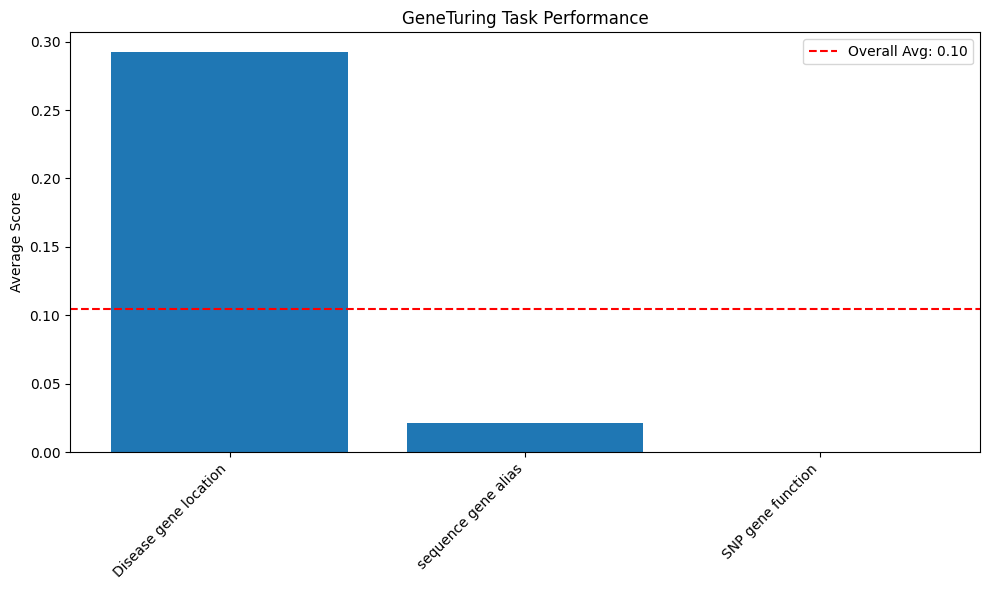

In [28]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score
import matplotlib.pyplot as plt
import pandas as pd
print(overall_score_by_task)

plt.figure(figsize=(10, 6))
plt.bar(overall_score_by_task.keys(), overall_score_by_task.values)
plt.axhline(y=overall_score, color='red', linestyle='--', label=f'Overall Avg: {overall_score:.2f}')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Score')
plt.title('GeneTuring Task Performance')
plt.legend()
plt.tight_layout()

# 保存图像
os.makedirs("outputs", exist_ok=True)
output_path = 'outputs/gene_turing_scores_by_task.png'
plt.savefig(output_path)

output_path


In [29]:


import mlflow
import os

# 确保输出目录存在
os.makedirs("outputs", exist_ok=True)
# 1. 把 MLflow 服务器加到 NO_PROXY
os.environ["NO_PROXY"] = os.environ.get("NO_PROXY", "") + ",198.215.61.34"
os.environ["no_proxy"] = os.environ["NO_PROXY"]               # 有些系统区分大小写

# 2. 彻底屏蔽代理变量（对当前 Python 进程）
for var in ("http_proxy", "https_proxy", "HTTP_PROXY", "HTTPS_PROXY"):
    os.environ.pop(var, None)
# 设置远程 tracking server
mlflow.set_tracking_uri("http://198.215.61.34:8153/")
mlflow.set_experiment("Yi")

try:
    with mlflow.start_run(run_name="v2-openai"):
        # 参数记录
        mlflow.log_param("model_name", model_config.model_name)
        mlflow.log_param("backend", model_config.model_backend)

        # 分数记录
        mlflow.log_metric("overall_score", overall_avg)
        for task, avg in task_avg.items():
            mlflow.log_metric(f"{task.replace(' ', '_')}_score", avg)

        # 上传文件产物
        mlflow.log_artifact("outputs/gene_turing_scores_by_task.png", artifact_path="figures")
        mlflow.log_artifact("outputs/gene_turing_results.csv", artifact_path="predictions")

except Exception as e:
    print(f"[MLflow Error] Logging failed: {e}")


🏃 View run v2-openai at: http://198.215.61.34:8153/#/experiments/3/runs/9d08e900bd4645f08dd646041e8dc525
🧪 View experiment at: http://198.215.61.34:8153/#/experiments/3
